Steane Code FTc encoding and detection
================================= 

1. Set up fault tolerant logical zero using method c for Steane code based on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up fault tolerant ancilla as also described in Nielsen and Chuang.

3. Carry out the error correction in software. 

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

from helper_functions import (
    get_noise, 
    count_valid_output_strings,
    string_reverse,
    process_FT_results, 
    mean_of_list,
    calculate_standard_error
    )

In [2]:
SINGLE_GATE_ERRORS = ['x', 'y', 'z', 'h', 's', 'sdg']
TWO_GATE_ERRORS = ['cx', 'cz']

QUBIT_LIST = [2,4,5]

ANC_ZERO = '0000'
ANC_ONE = '0001'
ANCILLA_TYPES = 2
ANCILLA_QUBITS = 3
ANCILLA_MEASUREMENT_REPEATS = 3
DATA_MEASUREMENT_REPEATS = 3
DATA_MEAS_START = ANCILLA_TYPES * ANCILLA_QUBITS * ANCILLA_MEASUREMENT_REPEATS
DATA_MEAS_QUBITS = 1
DATA_START = DATA_MEAS_START + (DATA_MEAS_QUBITS * DATA_MEASUREMENT_REPEATS)

TESTING = False                          #Test by applying and X or Z error to one of the qubits
TEST_X_QUBIT = 0                         #Qbit to set bit flip- Starts at zero.
TEST_X_LOGICAL = 0                       #logical Qbit to set bit flip- Starts at zero.
TEST_Z_QUBIT = 0                         #Qbit to phase flip- Starts at zero.
TEST_Z_LOGICAL = 0                       #logical Qbit to set phase flip- Starts at zero.

NOISE = True                             #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022
ITERATIONS = 25

FACTOR = 1
SIMULATOR = Aer.get_backend('qasm_simulator')
SPACE = ' '
DATA_QUBITS = 7

In [3]:
parity_check_matrix = ['0001111',
                       '0110011',
                       '1010101'
                      ]

In [4]:
codewords = ['0000000',
             '1010101',
             '0110011',
             '1100110',
             '0001111',
             '1011010',
             '0111100',
             '1101001'
            ]

In [5]:
if NOISE:
    noise_model = get_noise(MEASURE_NOISE * FACTOR, SINGLE_GATE_DEPOLARISING * FACTOR, 
                            TWO_GATE_DEPOLARISING * FACTOR, SINGLE_GATE_ERRORS, 
                            TWO_GATE_ERRORS )

In [6]:
rejected_accum = 0
accepted_accum = 0
valid_accum = 0
invalid_accum = 0
results = []
for iteration in range(ITERATIONS):
    print()
    print(f'Iteration {iteration}')
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, 
                               fault_tolerant_ancilla = True, fault_tolerant_c = True, 
                               ancilla_rounds = 3, data_rounds = 3
                              )
    qubit.set_up_logical_zero(0)
    for i in range(DATA_MEASUREMENT_REPEATS):
        qubit.barrier()
        qubit.encode_fault_tolerant_method_C(QUBIT_LIST)
        qubit.logical_measure_data_FT(0, i + 1)
    if TESTING:
        qubit.force_X_error(TEST_X_QUBIT, TEST_X_LOGICAL)   #force X error for testing
    #qubit.force_Z_error(TEST_Z_QUBIT,TEST_Z_LOGICAL)   #force Z error for testing
        qubit.barrier()
    for i in range(ANCILLA_MEASUREMENT_REPEATS):
        qubit.set_up_ancilla(0)
        qubit.logical_measure_ancilla(0, i)
    qubit.logical_measure_data(0)
    if NOISE:
        result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qubit, SIMULATOR, shots=SHOTS).result()
    counts = result.get_counts(qubit)
    error_rate, rejected, accepted, valid, invalid = process_FT_results(counts, codewords, 
                                                                        anc_zero = ANC_ZERO,
                                                                        anc_one = ANC_ONE,
                                                                        verbose = True,  
                                                                        data_meas_start = DATA_MEAS_START, 
                                                                        data_start = DATA_START,
                                                                        ancilla_qubits = ANCILLA_QUBITS, 
                                                                        ancilla_meas_repeats = ANCILLA_MEASUREMENT_REPEATS,
                                                                        data_meas_qubits = DATA_MEAS_QUBITS, 
                                                                        data_meas_repeats = DATA_MEASUREMENT_REPEATS
                                                                        )
    rejected_accum = rejected + rejected_accum
    accepted_accum = accepted_accum + accepted
    valid_accum = valid_accum + valid
    invalid_accum =  invalid_accum + invalid    
    results.append(error_rate)    
mean_error_rate = mean_of_list(results)
standard_deviation, standard_error = calculate_standard_error(results)
print(f'There are {rejected_accum} strings rejected and {accepted_accum} strings submitted for processing')
print(f'Of these {accepted_accum} strings processed there are {valid_accum} valid strings and {invalid_accum} invalid_strings')
print(f'The error rate is {mean_error_rate:.4f} and the standard error is {standard_error:.4f} ')
print(f'the standard deviation is {standard_deviation:.4f} ')


Iteration 0
At the data validation stage
There are 2447 strings rejected and 7553 strings submitted for processing
Making 10000 in total submitted for data processing

At the ancilla validation stage
There are 7521 strings rejected and 32 strings submitted for validation
Making 7553 in total submitted to check validity

Of these 32 strings validated there are 29 valid strings and 3 invalid_strings
The error rate is 0.0938

Iteration 1
At the data validation stage
There are 2482 strings rejected and 7518 strings submitted for processing
Making 10000 in total submitted for data processing

At the ancilla validation stage
There are 7489 strings rejected and 29 strings submitted for validation
Making 7518 in total submitted to check validity

Of these 29 strings validated there are 24 valid strings and 5 invalid_strings
The error rate is 0.1724

Iteration 2
At the data validation stage
There are 2368 strings rejected and 7632 strings submitted for processing
Making 10000 in total submitte

At the data validation stage
There are 2427 strings rejected and 7573 strings submitted for processing
Making 10000 in total submitted for data processing

At the ancilla validation stage
There are 7542 strings rejected and 31 strings submitted for validation
Making 7573 in total submitted to check validity

Of these 31 strings validated there are 26 valid strings and 5 invalid_strings
The error rate is 0.1613

Iteration 21
At the data validation stage
There are 2505 strings rejected and 7495 strings submitted for processing
Making 10000 in total submitted for data processing

At the ancilla validation stage
There are 7472 strings rejected and 23 strings submitted for validation
Making 7495 in total submitted to check validity

Of these 23 strings validated there are 18 valid strings and 5 invalid_strings
The error rate is 0.2174

Iteration 22
At the data validation stage
There are 2466 strings rejected and 7534 strings submitted for processing
Making 10000 in total submitted for data 

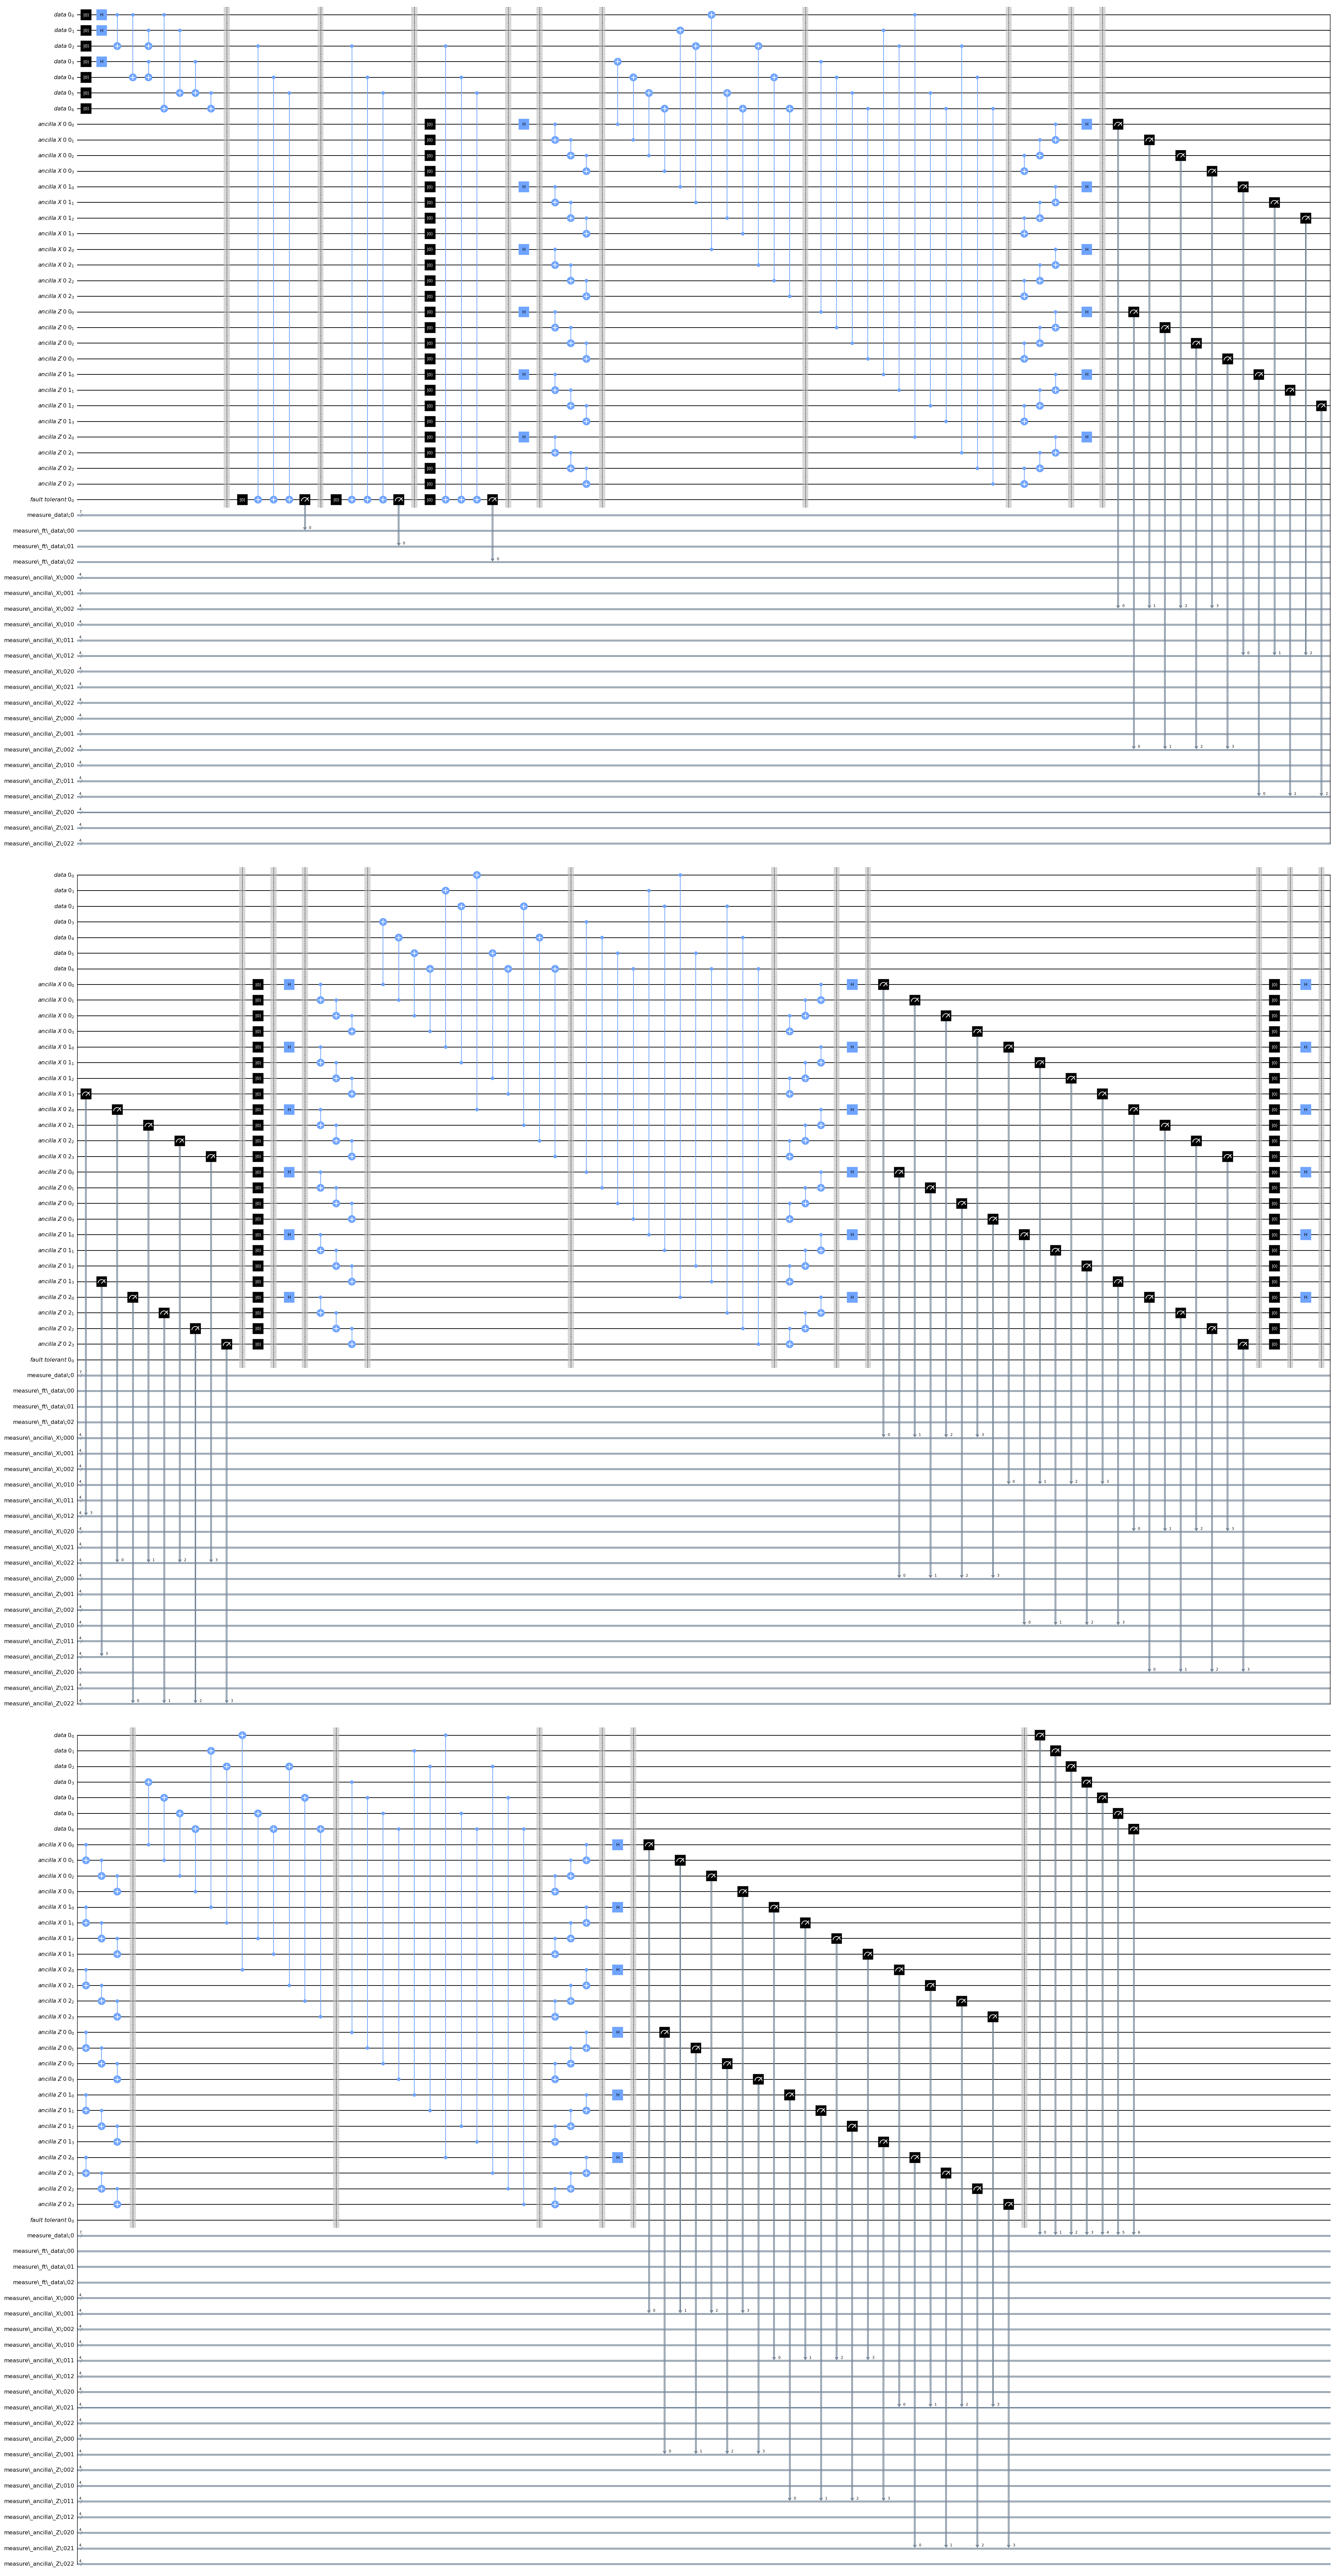

In [7]:
qubit.draw(output='mpl', filename = 'Steane_code_FTc_encoding_and_detection_circuit.jpg', fold = 80)